###**Aplicación de filtros de derivadas verticales (primeras y segundas) y espaciales a datos magnéticos**###
####**Alumna:** Stephany Ramírez####
#####Los datos elegidos para el procesamiento constan de mediciones magnéticas sobre un borde de placa o margen continental pasivo, donde se pretende observar las diversas estructuras de la corteza que habitan en el mismo.#####

In [1]:
#Importo módulos
import numpy as np
import numpy
import sys
numpy.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib as mpl
#

###**Defino subrutinas útiles**###

In [2]:
#Defino el número de onda en cada dirección y el número de onda radial
def deriv (nx,ny,delx,dely):
    #
    kx = np.zeros(nx, dtype=float)
    #
    #Evaluando cada k y preguntando si k >= Nyquist == pi
    #
    dk = (2 * np.pi / nx)
    #
    for j in np.arange(nx):
        kx[j] = dk * j
        if kx[j] >= np.pi:
            kx[j] = kx[j] - 2.0 * np.pi
    #
    # Para mayor facilidad, para calcular ky, definiremos:
    #
    ky = kx
    #
    #Calculo el numero de onda radial
    kr = np.zeros(nx*ny).reshape(nx,ny)
    #
    for i in np.arange(nx):
        kr[i, :] = np.sqrt((kx[i]/delx)** 2 + (ky[:]/dely)** 2)
    #
    Kx=kx/delx
    Ky=ky/dely
    #
    return kr,Kx,Ky
#

###**Extraigo datos y defino la malla de trabajo**###

In [3]:
x, y, dato = np.loadtxt("http://carina.fcaglp.unlp.edu.ar/~jgomez/academic/mpp/data/mag-sintetico.dat").T # x [m], y [m], T [nT]
nx, ny   = 200, 200
xx       = np.reshape(x, (ny,nx))
yy       = np.reshape(y, (ny,nx))
dato     = np.reshape(dato, (ny,nx))
#
#Llevamos los datos al dominio de los números de onda
T        = np.fft.fft2(dato)
#

###**Aplicación de las subrutinas como filtros a los datos**###

In [4]:
###########################################DERIVADAS VERTICALES###################################################
#
#Defino el orden de la derivada y los delx y dely
dely   = y[2]-y[1]
delx   = dely
#
n1     = 1
n2     = 2
#
kr,Kx,Ky     = deriv(nx,ny,delx,dely)
filtro1 = kr**n1
filtro2 = kr**n2
#
#Filtramos por el método de la derivada vertical
T_fil1  = filtro1*T
T_fil2  = filtro2*T
#
#Llevamos al dominio original
t_fil1  = np.real(np.fft.ifft2(T_fil1))
t_fil2  = np.real(np.fft.ifft2(T_fil2))
#
###########################################DERIVADAS ESPACIALES###################################################
#
#Genero malla para poder multiplicar celda a celda el filtro y los datos
kx,ky =np.meshgrid(Kx,Ky)
filtro3 = (1j)*kx
filtro4 = (1j)*ky
#
#Aplicamos los filtros
#Filtramos por el método de la derivada espacial en x y en y
T_fil3  = filtro3*T
T_fil4  = filtro4*T
#
#Llevamos al dominio original
t_fil3  = np.real(np.fft.ifft2(T_fil3))
t_fil4  = np.real(np.fft.ifft2(T_fil4))
#
grad_tot=np.sqrt(t_fil1**2+t_fil3**2+t_fil4**2)
#

###**Generación de productos**###

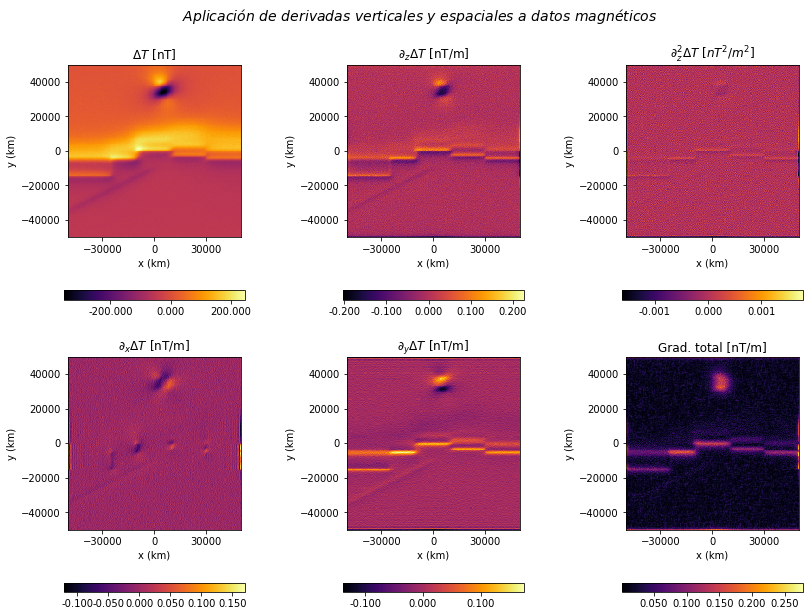

In [5]:
#Gráfico de los datos anteriores
dat = [dato,t_fil1,t_fil2,t_fil3,t_fil4,grad_tot]
names   = [r'$\Delta T$ [nT]',r"$\partial_{z} \Delta T$ [nT/m]",
           r"$\partial_{z}^2 \Delta T$ $[nT^2/m^2]$",r"$\partial_{x} \Delta T$ [nT/m]",
           r"$\partial_{y} \Delta T$ [nT/m]","Grad. total [nT/m]"]
#
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.1, wspace=0, top=0.9)
fig.suptitle('$Aplicación\,\,de\,\,derivadas\,\,verticales\,\,y\,\,espaciales\,\,a\,\,datos\,\,magnéticos$',fontsize=14)
#
for ax, dat,names in zip(axes.flat, dat,names):
    im=ax.imshow(dat, origin="lower",interpolation='nearest',extent=[min(x),max(x),min(y),max(y)], cmap='inferno')
    ax.set_title(names)
    ax.set_xlabel("x (km)")
    ax.set_ylabel("y (km)")
    loc = plticker.MultipleLocator(base=30000)
    ax.xaxis.set_major_locator(loc)
    fig.colorbar(im,ax=ax, orientation='horizontal',pad=0.2,shrink=0.65,spacing='uniform',format='%.3f')
plt.show()

###**Comentarios**###
#####En los productos gráficos podemos observar en primera instancia, las estructuras que se encuentran en el margen pasivo: diques, el borde de la corteza continental y oceánica, una estructura tabular (dique) y un cuerpo instrusivo bastante marcado. En los siguientes gráficos es notable el efecto que tiene la aplicación de la derivada primera y segunda en la dirección vertical. En la primera imágen podemos visualizar cómo se acentua el margen pasivo y las estructuras del subsuelo y en el segundo gráfico el mismo efecto, pero con la desventaja de que al filtrar se ha introducido una componente ruidosa. Dependiendo del objetivo del estudio, esta componente ruidosa podría ser una amenaza para los datos, por ejemplo, si el objetivo era observar estructuras igneas en la zona, probablemente la segunda derivada vertical no nos beneficiaría ya que como se observa, el dique se ve solapado por la cantidad de ruido introducido, impidiendo una buena interpretación.#####

#####Los siguientes tres gráficos muestran el efecto de las derivadas en las componentes horizontales, así como la magnitud del gradiente total. Es interesante observar que los datos filtrados por medio de la derivada en la dirección X, tienen menos resolución que en la dirección Y donde sí pueden distinguirse claramente las estructuras presentes. Finalmente, la magnitud del gradiente, también exhibe un carácter importante en la interpretación de los datos magnéticos, ya que es otra alternativa para visualizarlos, nuevamente esto dependerá dle objetivo de estudio. Para esta oportunidad, en este último gráfico se acentúa bastante el cuerpo ignéo y el margen pasivo y con un cierto grado de dificultad se puede notar el dique#####